In [ ]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="darkgrid")
%matplotlib inline

import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import f1_score, precision_score, recall_score
import pickle

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Utility Functions
def text_cleaning(text):
    """
    Clean the text using NLP and regular expressions

    text = Uncleaned text
    """
    text = re.sub(r'https?://\S+|www\.\S+', 'URL', text)
    text = re.sub(r'<.*?>', '', text)
    text = ''.join([char for char in text if char in string.printable])
    text = re.sub(r'@\S+', 'USER', text)
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text

In [ ]:
# Fetching reddit data
data = pd.read_csv("/Reddit_Data.csv.zip")
# Renaming column
data.rename({'clean_comment':'clean_text'}, axis=1, inplace=True)
data.head()

,clean_text,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [ ]:
# Checking datatypes/shape of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  37149 non-null  object
 1   category    37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [ ]:
# Checking Statistical Summary of data
data.describe(include='all')

,clean_text,category
count,37149,37249.000000
unique,36799,NaN
top,,NaN
freq,115,NaN
mean,NaN,0.202771
std,NaN,0.778515
min,NaN,-1.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


In [ ]:
# Checking null values
print(data.isnull().sum())
print()
# Removing null values
data.dropna(inplace=True)
print(data.isnull().sum())

clean_text    100
category        0
dtype: int64

clean_text    0
category      0
dtype: int64


In [ ]:
# Checking duplicated values
print(data.duplicated().sum())
print()
# Removing duplicated values
data.drop_duplicates(inplace=True)
data.duplicated().sum()

350



0

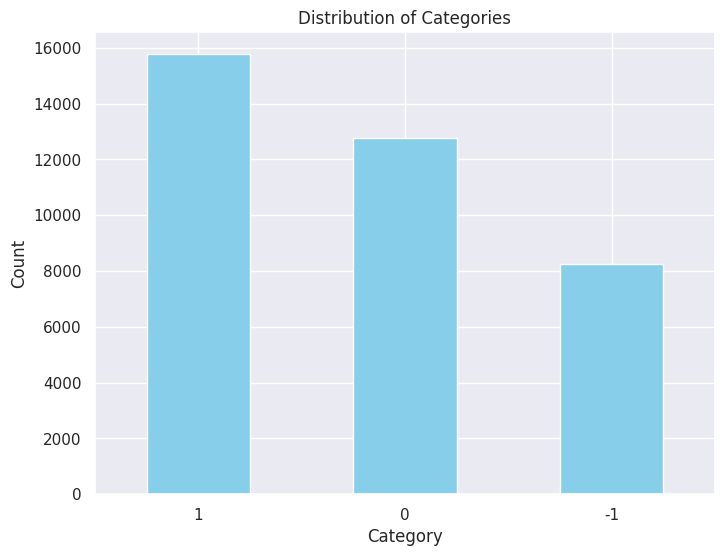

In [ ]:
# Checking the distribution of categories
category_counts = data['category'].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

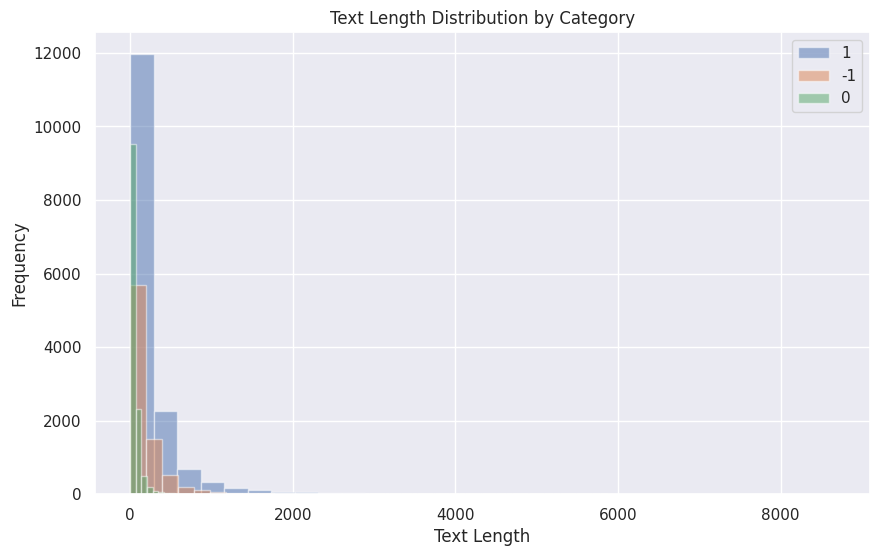

In [ ]:
# Performing Text Length Analysis
data['text_length'] = data['clean_text'].apply(len)
plt.figure(figsize=(10, 6))
for category in data['category'].unique():
    subset = data[data['category'] == category]
    plt.hist(subset['text_length'], bins=30, alpha=0.5, label=category)
plt.title('Text Length Distribution by Category')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

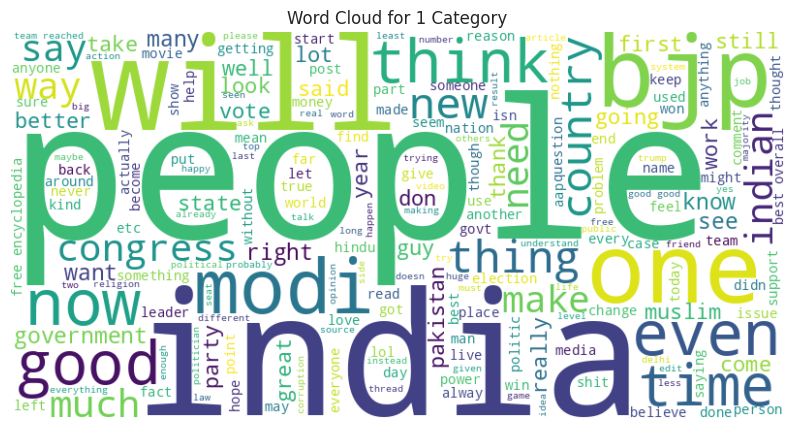

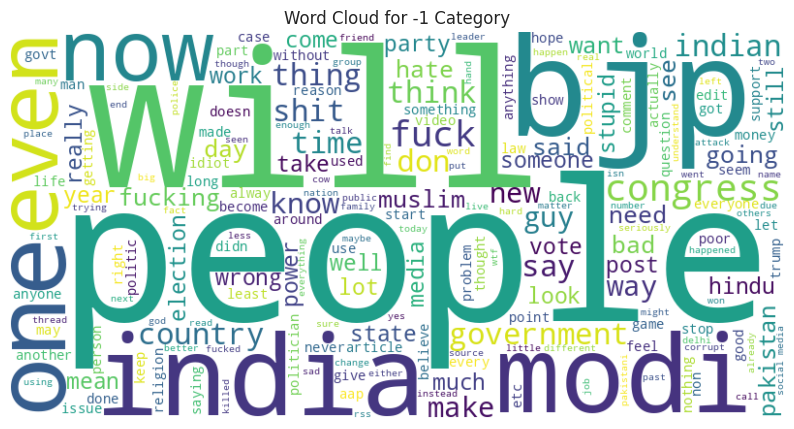

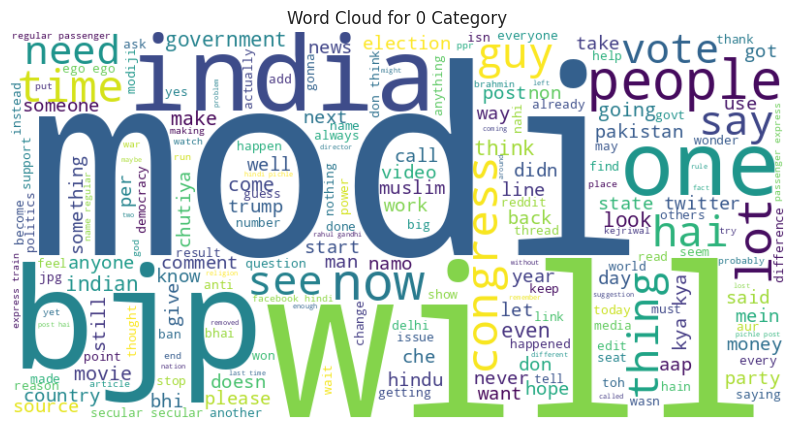

In [ ]:
# Creating wordcloud for each category
categories = data['category'].unique()
for category in categories:
    text = " ".join(data[data['category'] == category]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category} Category')
    plt.axis("off")
    plt.show()

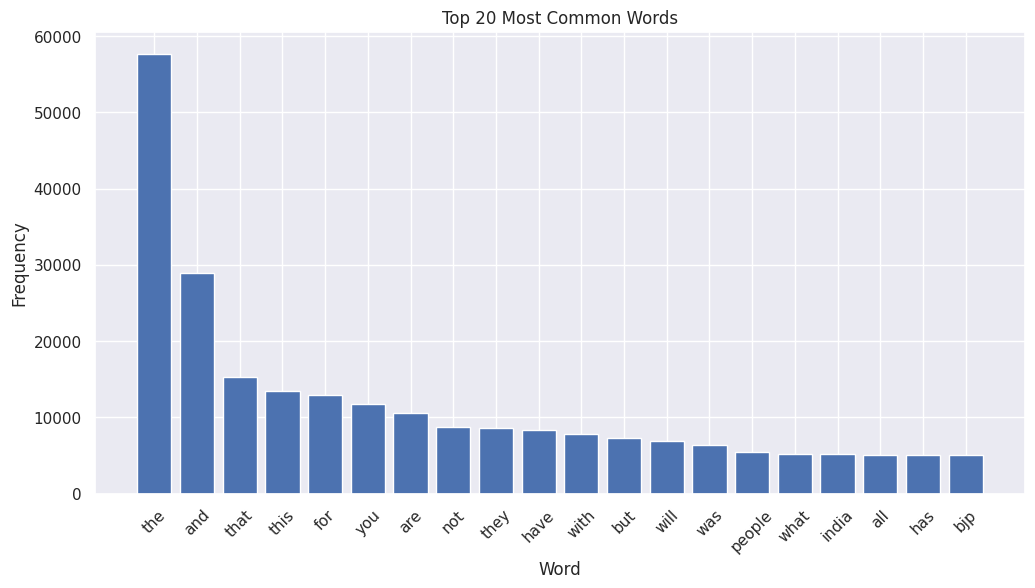

In [ ]:
# Calculating Word Frequency
all_text = " ".join(data['clean_text'])
words = all_text.split()
word_counts = Counter(words)
stopwords = set(STOPWORDS)
top_words = word_counts.most_common(20)
plt.figure(figsize=(12, 6))
plt.bar(*zip(*top_words))
plt.title('Top 20 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['category'], test_size=0.2, random_state=42)

In [ ]:
# Encoding the target labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# Checking the mapping
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:")
for class_label, encoded_value in class_mapping.items():
    print(f"{class_label}: {encoded_value}")

Class Mapping:
-1: 0
0: 1
1: 2


In [ ]:
# Tokenizing and padding the text data
max_words = 10000
max_sequence_length = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequence, maxlen=max_sequence_length)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequence, maxlen=max_sequence_length)
# Saving the tokenizer for future use
tokenizer_filename = 'tokenizer.pkl'
with open(tokenizer_filename, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

In [ ]:
# Hyperparameters
embedding_dim = 100
batch_size = 64
epochs = 10

In [ ]:
# Building the LSTM model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [ ]:
# Compiling & training
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
414/414 [==============================] - 82s 192ms/step - loss: 0.6361 - accuracy: 0.7302 - val_loss: 0.3223 - val_accuracy: 0.8849
Epoch 2/10
414/414 [==============================] - 76s 184ms/step - loss: 0.2947 - accuracy: 0.9052 - val_loss: 0.2728 - val_accuracy: 0.9076
Epoch 3/10
414/414 [==============================] - 78s 189ms/step - loss: 0.1731 - accuracy: 0.9499 - val_loss: 0.2884 - val_accuracy: 0.9022
Epoch 4/10
414/414 [==============================] - 76s 184ms/step - loss: 0.1327 - accuracy: 0.9640 - val_loss: 0.3157 - val_accuracy: 0.8981
Epoch 5/10
414/414 [==============================] - 74s 180ms/step - loss: 0.1091 - accuracy: 0.9711 - val_loss: 0.3700 - val_accuracy: 0.9032
Epoch 6/10
414/414 [==============================] - 77s 186ms/step - loss: 0.0938 - accuracy: 0.9754 - val_loss: 0.3720 - val_accuracy: 0.9029
Epoch 7/10
414/414 [==============================] - 76s 184ms/step - loss: 0.0777 - accuracy: 0.9788 - val_loss: 0.3935 - val_ac

In [ ]:
# Evaluation on Test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

230/230 [==============================] - 6s 24ms/step - loss: 0.4602 - accuracy: 0.8917
Test Loss: 0.4602
Test Accuracy: 0.8917


In [ ]:
# Predictions on Test data
y_test_pred = model.predict(X_test_padded)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

230/230 [==============================] - 6s 22ms/step


In [ ]:

# Calculate additional metrics
f1 = f1_score(y_test, y_test_pred_classes, average='weighted')
precision = precision_score(y_test, y_test_pred_classes, average='weighted')
recall = recall_score(y_test, y_test_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

F1 Score: 0.8926
Precision: 0.8941
Recall: 0.8917


In [ ]:
# Saving the model to a file
model.save('LSTM.h5')

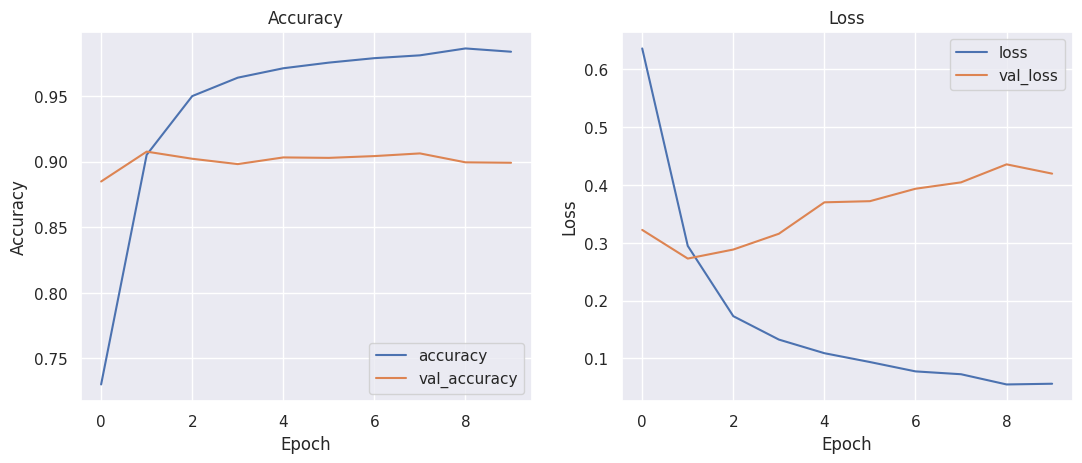

In [ ]:
# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
user_input = "You are very good!!, keep it up"
user_sequences = tokenizer.texts_to_sequences([user_input])
user_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_sequence_length)
from keras.models import load_model
loaded_model = load_model("LSTM.h5")
class_mapping={
0:'Negative',
1:'Neutral',
2:'Positive'}
# Make predictions on user input
user_predictions = loaded_model.predict(user_padded)
# Convert predictions to class labels (assuming it's a classification task)
user_pred_classes = np.argmax(user_predictions, axis=1)
# Print the predicted class
print(f'Predicted Class: {class_mapping[user_pred_classes[0]]}')

1/1 [==============================] - 0s 414ms/step
Predicted Class: Positive
